# Explaining Models with FW Perturbations

In [1]:
from pathlib import Path

import numpy as np

import torch
ch = torch
from torchvision.transforms import Normalize

import Attackers as A
from tools import dit, inet_name, show_image_row
from resnet import resnet50

normit = Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# Some Data

These images were chosen based on the resnet50 L2 model from https://github.com/MadryLab/robustness so they may not correspond to correct / error examples for your model.

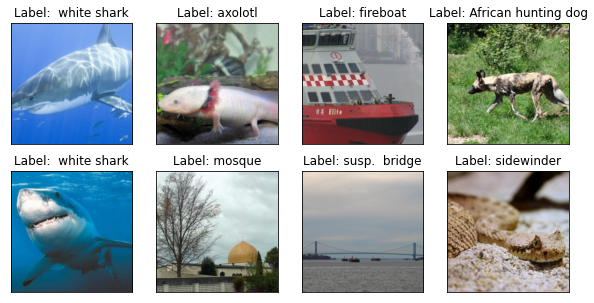

In [2]:
img_dir = Path('input_images')

cor_imgs = np.load(img_dir.joinpath('cor_img.npy'))
err_imgs = np.load(img_dir.joinpath('err_img.npy'))

cor_lbls = np.load(img_dir.joinpath('cor_lbls.npy'))
err_lbls = np.load(img_dir.joinpath('err_lbls.npy'))

cor_imgs = ch.from_numpy(cor_imgs)
err_imgs = ch.from_numpy(err_imgs)

cor_lbls = ch.from_numpy(cor_lbls)
err_lbls = ch.from_numpy(err_lbls)

labels = [inet_name(l.item(), tag="Label: ") for l in dit(cor_lbls)]
labels = [labels, [inet_name(l.item(), tag="Label: ") for l in dit(err_lbls)]]

fig = show_image_row([cor_imgs, err_imgs], tlist=labels)

# Explain a model

You can use any model you like by changing this next block. We have provided a resnet50 class together with weights which you can find here:

https://github.com/MadryLab/robustness



In [5]:
model = resnet50(num_classes=1000, pretrained=False)

model.load_state_dict(torch.load("resnet50_imagenet_L2_3p0_state_dict.pt"))
model.eval()
_ = model.cuda()

In [6]:
# Get model predictions
cor_pred = model(normit(cor_imgs.cuda()))
cor_pred = dit(torch.argmax(cor_pred, dim=1))

err_pred = model(normit(err_imgs.cuda()))
err_pred = dit(torch.argmax(err_pred, dim=1))
cor_pred, cor_lbls

(tensor([  2,  29, 628, 272]), tensor([  2,  29, 554, 275]))

## Error Explanation

We modify the input image to increase the model's confidence in its prediction or in the correct class. We will compare 3 different optimizations to get a more full picture of the prediction process. Though it isn't an exact science the 3 different optimizations have the following heuristics

- **Linf**: Perturbations are very dense and pronounced, these sometimes reveal high level patterns a model has learned.
- **L2**: Perturbations are dense but smooth. These tend to capture textures as well as some local features.
- **L1q** (ours): Perturbations are sparse and reasonably smooth. These capture localized features.



For the provided resnet50 the following errors took place

The model mistook a
 
- **white shark** for a **tiger shark**
- **mosque** for a **barn**
- **susp.  bridge** for a **sandbar**
- **sidewinder** for a **horned viper**


NOTE: ImageNet has no idea what a tiger shark is this class is highly mislabeled. Same goes for sidewinder vs. horned viper, it appears these may actually be almost the same snake but found in different regions.


In [65]:
imgdir = Path("images")
imgdir.mkdir(exist_ok=True)

T = 55
linf_eps = 0.25
l2_eps = 15.0

# Percetn of pixels to modify each step
p = 0.005

N = 224*224*3
l1_eps =  l2_eps* pow(N, 0.5) # Chosen so the L1 q ball contains the L2 ball
l1_T = T * 3 # L1 needs more steps as it modifies fewer pixels at a time

attackers = {
    "Linf": A.FWLinfAttacker(num_steps=T, epsilon=linf_eps),
    "L2": A.FWL2Attacker(num_steps=T, epsilon=l2_eps),
    "L1-q": A.FWL1Attacker(num_steps=T, epsilon=l1_eps, q=1-p)
}

### Why did the model make this error?
Here we make the model more confident in its incorrect prediction to try and understand why the error was made.

Linf <Attackers.FWLinfAttacker object at 0x7fce881d7a00>
L2 <Attackers.FWL2Attacker object at 0x7fce783d4400>
L1-q <Attackers.FWL1Attacker object at 0x7fce704183a0>


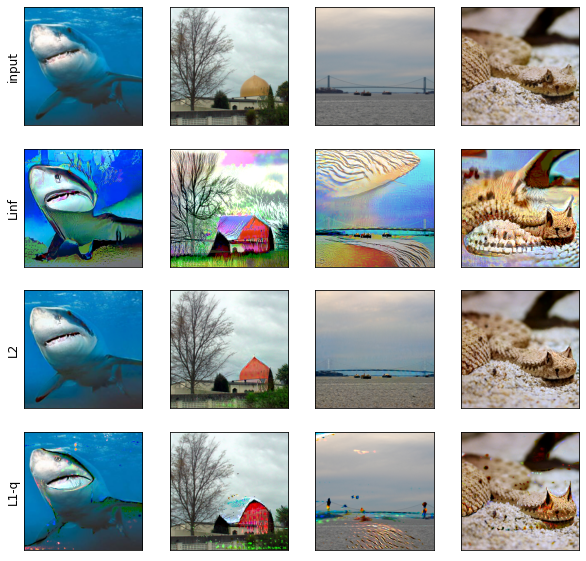

In [66]:
row = [x0.clamp(0,1) for x0 in err_imgs]

error_exp = {}
top_row = [[x0.clamp(0,1) for x0 in err_imgs]]
for k in attackers:
    atk = attackers[k]
    print(k, atk)
    delta = atk.get_adv_perturbation(
                    model, normit(err_imgs).cuda(), err_pred.cuda(), targeted=True
                )
    
    error_exp[k] = dit(delta) + err_imgs
    xadv = dit(delta) + err_imgs
    top_row.append([x0.clamp(0,1) for x0 in xadv])

ylist = ["input"] + [k for k in error_exp]
fig = show_image_row(top_row, ylist=ylist)
fig.savefig(imgdir.joinpath("err_targ_pred.png"), bbox_inches="tight")

The perturbations suggest

1. The model has no idea what a tiger shark looks like.
2. The dome of the mosque was mistaken for the front of a barn.
3. The tan in the sky and brownish water may have been mistaken for a sandbar, and the suspension cable was easily hidden.
4. The sidewinder's horned eyes are similar to a horned viper's eyes.

### What might have corrected this error?
Here we make the model more confident in the correct label to try and understand why the error was made.

Linf <Attackers.FWLinfAttacker object at 0x7fce881d7a00>
L2 <Attackers.FWL2Attacker object at 0x7fce783d4400>
L1-q <Attackers.FWL1Attacker object at 0x7fce704183a0>


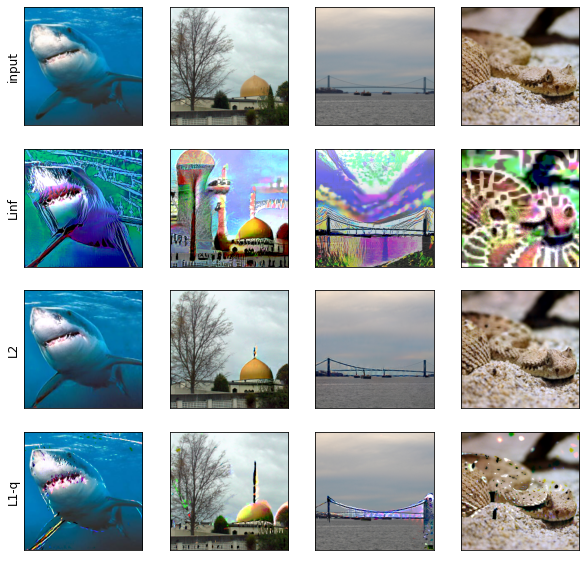

In [67]:
row = [x0.clamp(0,1) for x0 in err_imgs]

error_exp = {}
top_row = [[x0.clamp(0,1) for x0 in err_imgs]]
for k in attackers:
    atk = attackers[k]
    print(k, atk)
    delta = atk.get_adv_perturbation(
                    model, normit(err_imgs).cuda(), err_lbls.cuda(), targeted=True
                )
    
    error_exp[k] = dit(delta) + err_imgs
    xadv = dit(delta) + err_imgs
    top_row.append([x0.clamp(0,1) for x0 in xadv])

ylist = ["input"] + [k for k in error_exp]
fig = show_image_row(top_row, ylist=ylist)
fig.savefig(imgdir.joinpath("err_targ_lbl.png"), bbox_inches="tight")

The perturbations suggest

1. Adding "shark cage" like features would help with the white shark prediction.
2. The model associates minarets with mosques. The original minaret is there but quite small.
3. The suspension cable needs to be more emphasized.
4. The sidewinder's horned eyes are similar to a horned viper's eyes.


# Concept Probing
By feeding the model a semantically meaningless input, random noise, and perturbing in the direction of a given class label we can see what visual concepts a model associates with the class. We use the FW-L1-q perturbations as these enforce a sparsity, forcing the model to localize its features. FW-L2 perturbations work as well and can show texture features associated with a class.


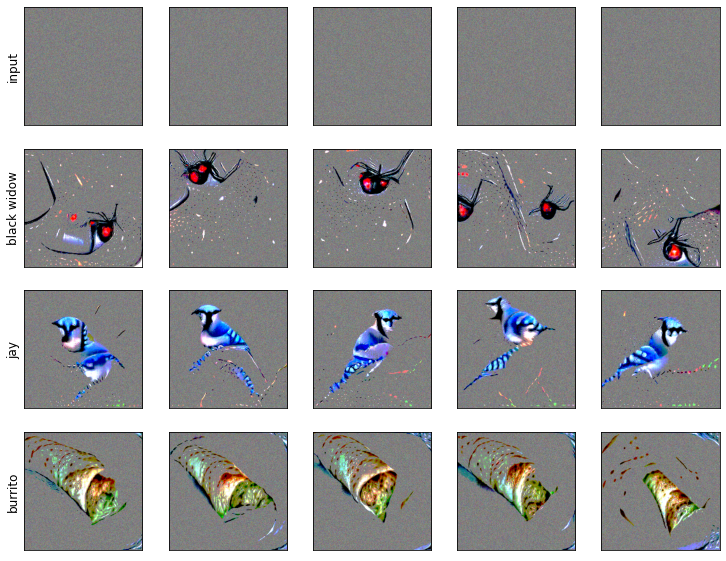

In [68]:
# Concept probing
NIMGS =5
imgs = 0.5 * ch.ones([NIMGS, 3, 224, 224])

noise = ch.rand([NIMGS, 3, 224, 224])
noise = 0.1 * 2 * (noise - 0.5)
imgs = imgs + noise

atk = A.FWL1Attacker(num_steps=250, epsilon=35.0*(N**0.5), q=0.995)


row = [x0.clamp(0,1) for x0 in imgs]

all_rows = [row]
all_ys = ["input"]
for tgt in [75, 17, 965]:
    targets = ch.ones((NIMGS,)).long()*tgt
    delta = atk.get_adv_perturbation(
                        model, normit(imgs).cuda(), targets.cuda(), targeted=True
                    )

    x_adv = dit(imgs) + dit(delta)

    row = [x0.clamp(0,1) for x0 in x_adv]
    all_rows.append(row)
    all_ys.append(inet_name(tgt))
    
fig = show_image_row(all_rows, ylist=all_ys)
fig.savefig(imgdir.joinpath("concept_probing.png"), bbox_inches="tight")

# Alternate Loss Functions
We can feed a custom loss function to visualize different features of the model. Here we perform model inversion similar to:

https://github.com/MadryLab/robust_representations/blob/master/image_inversion.ipynb

but we use FW-L1-q to generate sparse reconstructions.

In [48]:
# Custom loss for inversion
def inversion_loss(model, inp, targ):
    _, rep = model(inp, with_latent=True, fake_relu=True)
    loss = ch.div(ch.norm(rep - targ, dim=1), ch.norm(targ, dim=1))
    return loss.mean()

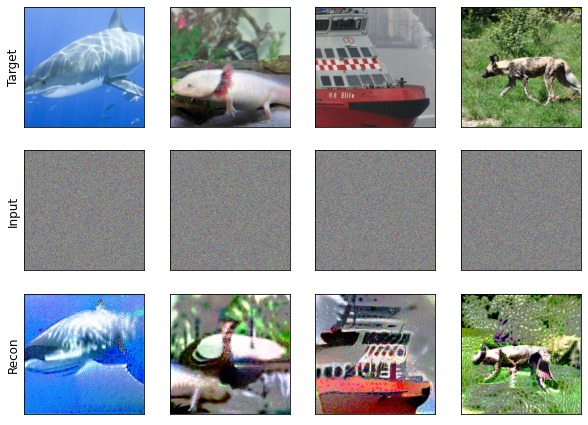

In [74]:
NIMGS = cor_imgs.shape[0]
imgs = ch.randn([NIMGS, 3, 224, 224])
imgs = imgs - imgs.min()
imgs = imgs / imgs.max()

with ch.no_grad():
    (_, rep) = model(normit(cor_imgs).cuda(), with_latent=True) # Corresponding representation 

atk = A.FWL1Attacker(num_steps=24500, epsilon=1500.0*(N**0.5), q=0.995)

targets = rep
delta = atk.get_adv_perturbation(
                    model, normit(imgs).cuda(), targets.cuda(),
                    loss_fn=inversion_loss, targeted=True
                )

x_adv = dit(imgs) + dit(delta)

xrow = [x0.clamp(0,1) for x0 in cor_imgs]
row = [x0.clamp(0,1) for x0 in x_adv]
ins = [x0.clamp(0,1) for x0 in imgs]
fig = show_image_row([xrow, ins, row], ylist=["Target", "Input", "Recon"])
fig.savefig("inversion_cor.png", bbox_inches="tight")